In [1]:
# preamble
from astropy.io import fits
import astropy.io.fits as pyfits

from matplotlib import pyplot as plt
import numpy as np
from numpy import append
from scipy.optimize import curve_fit
import scipy.stats

# 1 Get Observed Spectrum and DR3 Stellar Labels for SOBJECT_ID

In [2]:
working_directory = '/home/zhangxu/anaconda3/lib/python3.7/site-packages/The_Payne/other_data/GALAH_gbs_lbol_dr53/'

def read_spectra(sobject_id, SPECTRA = 'SPECTRA'):
    """
    This function reads in the 4 individual spectra from the subdirectory SPECTRA
    
    INPUT:
    sobject_id - identifier of spectra by date (6digits), plate (4digits), combination (2digits) and pivot number (3digits)
    SPECTRA - string to indicate sub directory where spectra are saved
    
    OUTPUT
    spectrum - dictionary
    """
    spectrum = dict(sobject_id = sobject_id)
    
    # Assess if spectrum is stacked
    if str(sobject_id)[11] == '1':
        # Single observations are saved in 'com'
        com='com'
    else:
        # Stacked observations are saved in 'com2'
        com='com'   
    
    # Iterate through all 4 CCDs
    for each_ccd in [1,2,3,4]:
        
        fits = pyfits.open(working_directory+str(sobject_id)+str(each_ccd)+'.fits')

        # Extension 0: Reduced spectrum
        # Extension 1: Relative error spectrum
        # Extension 4: Normalised spectrum, NB: cut for CCD4
        
        # Extract wavelength grid for the reduced spectrum
        start_wavelength = fits[0].header["CRVAL1"]
        dispersion       = fits[0].header["CDELT1"]
        nr_pixels        = fits[0].header["NAXIS1"]
        reference_pixel  = fits[0].header["CRPIX1"]
        
        if reference_pixel == 0:
            reference_pixel = 1
        spectrum['wave_red_'+str(each_ccd)] = np.array(list(map(lambda x:((x-reference_pixel+1)*dispersion+start_wavelength),range(0,nr_pixels))))
        
        # Extract wavelength grid for the normalised spectrum
        start_wavelength = fits[4].header["CRVAL1"]
        dispersion       = fits[4].header["CDELT1"]
        nr_pixels        = fits[4].header["NAXIS1"]
        reference_pixel  = fits[4].header["CRPIX1"]
        if reference_pixel == 0:
            reference_pixel=1
        spectrum['wave_norm_'+str(each_ccd)] = np.array(list(map(lambda x:((x-reference_pixel+1)*dispersion+start_wavelength),range(0,nr_pixels))))
        
        # Extract flux and flux error of reduced spectrum
        spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
        spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

        # Extract flux and flux error of reduced spectrum
        spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
        if each_ccd != 4:
            spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
        else:
            # for normalised error of CCD4, only used appropriate parts of error spectrum
            spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])
            
        fits.close()
    return spectrum    

In [3]:
def interpolate_spectrum_onto_cannon_wavelength(spectrum):
    """
    This function interpolates the spectrum 
    onto the wavelength grid of The Cannon as used for GALAH DR2
    
    INPUT:
    spectrum dictionary
    
    OUTPUT:
    interpolated spectrum dictionary
    
    """
    
    # Initialise interpolated spectrum from input spectrum
    interpolated_spectrum = dict()
    for each_key in spectrum.keys():
        interpolated_spectrum[each_key] = spectrum[each_key]
    
    # The Cannon wavelength grid as used for GALAH DR2
    wave_cannon = dict()
    wave_cannon['ccd1'] = np.arange(4715.94,4896.00,0.046) # ab lines 4716.3 - 4892.3
    wave_cannon['ccd2'] = np.arange(5650.06,5868.25,0.055) # ab lines 5646.0 - 5867.8
    wave_cannon['ccd3'] = np.arange(6480.52,6733.92,0.064) # ab lines 6481.6 - 6733.4
    wave_cannon['ccd4'] = np.arange(7693.50,7875.55,0.074) # ab lines 7691.2 - 7838.5
    
    for each_ccd in [1, 2, 3, 4]:
        
        # exchange wavelength
        interpolated_spectrum['wave_red_'+str(each_ccd)]  = wave_cannon['ccd'+str(each_ccd)]
        interpolated_spectrum['wave_norm_'+str(each_ccd)] = wave_cannon['ccd'+str(each_ccd)]
        
        # interpolate and exchange flux
        interpolated_spectrum['sob_red_'+str(each_ccd)]  = np.interp(
            x=wave_cannon['ccd'+str(each_ccd)],
            xp=spectrum['wave_red_'+str(each_ccd)],
            fp=spectrum['sob_red_'+str(each_ccd)],
            )
        interpolated_spectrum['sob_norm_'+str(each_ccd)]  = np.interp(
            wave_cannon['ccd'+str(each_ccd)],
            spectrum['wave_norm_'+str(each_ccd)],
            spectrum['sob_norm_'+str(each_ccd)],
            )

        # interpolate and exchange flux error
        interpolated_spectrum['uob_red_'+str(each_ccd)]  = np.interp(
            wave_cannon['ccd'+str(each_ccd)],
            spectrum['wave_red_'+str(each_ccd)],
            spectrum['uob_red_'+str(each_ccd)],
            )
        interpolated_spectrum['uob_norm_'+str(each_ccd)]  = np.interp(
            wave_cannon['ccd'+str(each_ccd)],
            spectrum['wave_norm_'+str(each_ccd)],
            spectrum['uob_norm_'+str(each_ccd)],
            )

    return interpolated_spectrum

In [4]:
def theil_sen(x, y, sample= False, n_samples = 100, use_thomas_implementation = True):
    '''
    This function applies a Theil-Sen normalisation to the input
    
    INPUT:
    spectrum - dictionary from read_spectra()
    
    OUTPUT:
    norm_spectrum - dictionary
    
    from https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/Estimators/theil_sen.py
    rewrite by Sven Buder.
    '''
    
    if use_thomas_implementation:
        num = x.shape[0]
        n = np.int64((num)*(num-1)/2)
        theil = y[0]*np.ones(n)
        t = 0
        
        # Loop over every ordered pair of points (i, j>i):
        for i in range(0,num-1):
            # Vectorized inner loop:
            j = np.arange(num-i-1)+i+1
            #print(len(y[j]),len(y[i]),len(x[j]),len(x[i]),len(t))
            theil[t:t+num-i-1] = (y[j]-y[i]) / (x[j]-x[i])
            t += num-i-1
        slope = np.median(theil)
        intercept = np.median(y - slope*x)
        
        return np.array([slope, intercept])
    
    else:
        
        def slope(x_1, x_2, y_1, y_2):
            return (1 - 2*(x_1>x_2))*((y_2 - y_1)/np.abs((x_2-x_1)))

        assert x.shape[0] == y.shape[0]

        n = x.shape[0]

        if n < n_samples or not sample:
            ix = np.argsort( x )
            slopes = np.empty(int(n*(n-1)*0.5))
            for c, pair in enumerate(itertools.combinations(range(n), 2)):
                i,j = ix[pair[0]], ix[pair[1]]
                slopes[c] = slope(x[i], x[j], y[i], y[j])
        else:
            i1 = np.random.randint(int(0), int(n), int(n_samples))
            i2 = np.random.randint(int(0), int(n), int(n_samples))
            slopes = slope(x[i1], x[i2], y[i1], y[i2])

        slope_ = bottleneck.nanmedian(slopes)
        #find the optimal b as the median of y_i - slope*x_i
        intercepts = np.empty(n)
        for c in range(n):
            intercepts[c] = y[c] - slope_*x[c]
        intercept_ = bottleneck.median(intercepts)

        return np.array([slope_, intercept_])

def slope(x_1, x_2, y_1, y_2):
    '''called by theil sen'''
    return (1 - 2*(x_1>x_2))*((y_2 - y_1)/np.abs((x_2-x_1)))

In [5]:
def renormalise_norm_spec_from_payne(wavelength, obs_spec, spectrum):
    '''
    divide the whole Payne fitted spectrum into multiple segments. 
    Theil sen estimator is used to fit Payne fitted spectrum segment/observed  spectrum segment. 
    Payne fitted spectrum is divided by the median (which is from Thile sen) to get renormalized spectrum. 
    '''
    start_wave = [4715, 4740, 4777, 4819, 4847, 4880, 5650, 5673, 5697, 5740, 5783, 5825, 5850, 6480, 6488, 6507, 6530, 6600, 6650, 6684, 6716, 7693, 7707, 7737, 7777, 7820, 7848]
    end_wave = [4740, 4777, 4819, 4847, 4880, 4900, 5673, 5697, 5740, 5783, 5825, 5850, 5900, 6488, 6507, 6530, 6600, 6650, 6684, 6716, 6750, 7707, 7737, 7777, 7820, 7848, 7900]

    renormalise_norm_spec = np.zeros(len(obs_spec))

    for i in range(len(start_wave)):
        
        norm_spec_from_payne_segment = spectrum[(start_wave[i] < wavelength) & (wavelength < end_wave[i])]
        
        norm_spec_segment = obs_spec[(start_wave[i] < wavelength) & (wavelength < end_wave[i])]
    
        'theil sen estimator'
        np.seterr(divide='ignore', invalid='ignore')
        fit = theil_sen(wavelength[(start_wave[i] < wavelength) & (wavelength < end_wave[i])], norm_spec_from_payne_segment/  norm_spec_segment)
        median = wavelength[(start_wave[i] < wavelength) & (wavelength < end_wave[i])]*fit[0] + fit[1]
        renorm_spec_from_payne_segment = norm_spec_from_payne_segment/median
        renormalise_norm_spec[(start_wave[i] < wavelength) & (wavelength < end_wave[i])] = renorm_spec_from_payne_segment  
#        print('kai2 spectrum and obs_spec:', scipy.stats.chisquare(f_obs=renormalise_norm_spec, f_exp=obs_spec))
    return renormalise_norm_spec

In [6]:
def get_stellar_labels(sobject_id, dr3_table='GALAH_DR3_main_200331.fits'):
    """
    get stellar labels corresponding to the given sobject_id
    
    INPUT:
    sobject_id - identifier of spectra by date (6digits), plate (4digits), combination (2digits) and pivot number (3digits)
    dr3_table - filename of DR3 main catalog with stellar parameter
    
    OUTPUT
    labels - labels for the specific sobject_id
    """
    a1 = fits.getdata('/home/zhangxu/anaconda3/lib/python3.7/site-packages/The_Payne/other_data/'+dr3_table,ext=1)
    idx=np.where(sobject_id==a1['sobject_id'])
    label=[a1['teff'][idx][0],a1['logg'][idx][0],a1['fe_h'][idx][0]]
    
    return label

# 2 Load Grid of Synthetic Spectra and define interpolation routines

In [7]:
def read_synthetic_grid(grid_file='GALAH-spectra-galahCN_63.fits'):
    """
    This function reads the synthetic grid into memory
    
    INPUT:
    grid_file - file provided by Thomas Nordlander (see email from 200615)
    
    OUTPUT:
    grid - dictionary
    
    """
    a1 = fits.getdata('/home/zhangxu/anaconda3/lib/python3.7/site-packages/The_Payne/other_data/'+grid_file,ext=1)[0]
    a2 = fits.getdata('/home/zhangxu/anaconda3/lib/python3.7/site-packages/The_Payne/other_data/'+grid_file,ext=2)
    
    model_grid=dict(
            WAVE = a1['WAVE'],
            TEFF = a1['TEFF'],
            LOGG = a1['LOGG'],
            FEH = a1['FEH'],
            CFE = a1['CFE'],
            smod = a2
        )
    return(model_grid)

In [8]:
def grid(teff=None,logg=None,feh=None,cfe=None):
    """
    Return synthetic spectra corrresponding to label
    
    INPUT:
    teff, logg, feh, cfe - values are same as grid label
    
    OUTPUT:
    grid - synthetic spectra
    """
    model_grid=read_synthetic_grid(grid_file='GALAH-spectra-galahCN_63.fits')
    index = np.where((teff==model_grid['TEFF'])&(logg==model_grid['LOGG'])&(feh==model_grid['FEH'])&(cfe==model_grid['CFE']))
    grid = model_grid['smod'][index]
    return np.array(grid)

In [9]:
def interpolate_synthetic_spectrum(labels, c_abund, interpolation_type='linear'):
    """
    This function interpolates within the synthetic grid.
    It gives back a synthetic spectrum corresponding to the labels+c_abund combination
    
    INPUT:
    grid - dictionary from read_synthetic_grid() or theil_sen_normalisation()
    labels - dictionary from get_stellar_labels()
    
    OUTPUT:
    synthetic_spectrum for the labels and c_abund
    
    """
    
    teff, logg, feh = labels
    cfe = c_abund
    
    grid_teffs = np.array([3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,
                           4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750,
                           7000,7250,7500,7750,8000])
    grid_loggs = np.array([0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5])
    grid_feh   = np.array([-2.,-1.5,-1.,-0.75,-0.5,-0.25,0.,0.25,0.5,0.75,1.])
    grid_cfe   = np.array([-1.,-0.5,-0.25,0.,0.25,0.5,1.])
    
    idx_teff_low = len(np.where(teff>=grid_teffs)[0])-1
    idx_logg_low = len(np.where(logg>=grid_loggs)[0])-1
    idx_feh_low = len(np.where(feh>=grid_feh)[0])-1
    idx_cfe_low = len(np.where(cfe>=grid_cfe)[0])-1
#     print('idx_cfe_low:',idx_cfe_low)
    
    idx_teff_high = idx_teff_low+1
    idx_logg_high = idx_logg_low+1
    idx_feh_high = idx_feh_low+1
    idx_cfe_high = idx_cfe_low+1

#     print('idx_cfe_high',idx_cfe_high)

    if interpolation_type=='scipy.interpn':
        spectrum = scipy.interpn(grid, values=[labels,c_abund])
        return(spectrum)

    if interpolation_type=='linear':
        
        print('You are using linear interpolation')
        
        # You want as a result:
        teff_grid_low = grid_teffs[idx_teff_low]
        teff_grid_high = grid_teffs[idx_teff_high]
        teff_weight = (teff_grid_high-teff)/(teff_grid_high-teff_grid_low)
        
#         print('Label in:',teff)
#         print('Closest grid points:',teff_grid_low,teff_grid_high)
#         print('We want to use that much of the lower Teff spectra')
#         print(teff_weight)
#         print('We want to use that much of the higher Teff spectra')
#         print(1-teff_weight)

        # same for logg
        logg_grid_low = grid_loggs[idx_logg_low]
        logg_grid_high = grid_loggs[idx_logg_high]
        logg_weight = (logg_grid_high-logg)/(logg_grid_high-logg_grid_low)
        
#         print('Label in:',logg)
#         print('Closest grid points:',logg_grid_low,logg_grid_high)
#         print('We want to use that much of the lower logg spectra')
#         print(logg_weight)
#         print('We want to use that much of the higher logg spectra')
#         print(1-logg_weight)
        
        # same for feh
        feh_grid_low = grid_feh[idx_feh_low]
        feh_grid_high = grid_feh[idx_feh_high]
        feh_weight = (feh_grid_high-feh)/(feh_grid_high-feh_grid_low)
        
#         print('Label in:',feh)
#         print('Closest grid points:',feh_grid_low,feh_grid_high)
#         print('We want to use that much of the lower feh spectra')
#         print(feh_weight)
#         print('We want to use that much of the higher feh spectra')
#         print(1-feh_weight)
        
        # same for cfe
        cfe_grid_low = grid_cfe[idx_cfe_low]
        cfe_grid_high = grid_cfe[idx_cfe_high]
        cfe_weight = (cfe_grid_high-cfe)/(cfe_grid_high-cfe_grid_low)
        
#         print('Label in:',cfe)
#         print('Closest grid points:',cfe_grid_low,cfe_grid_high)
#         print('We want to use that much of the lower cfe spectra')
#         print(cfe_weight)
#         print('We want to use that much of the higher cfe spectra')
#         print(1-cfe_weight)
        
        spectrum_0000 = grid(teff=teff_grid_low, logg=logg_grid_low, feh=feh_grid_low, cfe=cfe_grid_low)
        
        spectrum_1000 = grid(teff=teff_grid_high, logg=logg_grid_low, feh=feh_grid_low, cfe=cfe_grid_low)
        spectrum_0100 = grid(teff=teff_grid_low, logg=logg_grid_high, feh=feh_grid_low, cfe=cfe_grid_low)
        spectrum_0010 = grid(teff=teff_grid_low, logg=logg_grid_low, feh=feh_grid_high, cfe=cfe_grid_low)
        spectrum_0001 = grid(teff=teff_grid_low, logg=logg_grid_low, feh=feh_grid_low, cfe=cfe_grid_high)
        
        spectrum_1100 = grid(teff=teff_grid_high, logg=logg_grid_high, feh=feh_grid_low, cfe=cfe_grid_low)
        spectrum_1010 = grid(teff=teff_grid_high, logg=logg_grid_low, feh=feh_grid_high, cfe=cfe_grid_low)
        spectrum_1001 = grid(teff=teff_grid_high, logg=logg_grid_low, feh=feh_grid_low, cfe=cfe_grid_high)
        spectrum_0110 = grid(teff=teff_grid_low, logg=logg_grid_high, feh=feh_grid_high, cfe=cfe_grid_low)
        spectrum_0101 = grid(teff=teff_grid_low, logg=logg_grid_high, feh=feh_grid_low, cfe=cfe_grid_high)
        spectrum_0011 = grid(teff=teff_grid_low, logg=logg_grid_low, feh=feh_grid_high, cfe=cfe_grid_high)
        
        spectrum_1110 = grid(teff=teff_grid_high, logg=logg_grid_high, feh=feh_grid_high, cfe=cfe_grid_low)
        spectrum_0111 = grid(teff=teff_grid_low, logg=logg_grid_high, feh=feh_grid_high, cfe=cfe_grid_high)
        spectrum_1011 = grid(teff=teff_grid_high, logg=logg_grid_low, feh=feh_grid_high, cfe=cfe_grid_high)
        spectrum_1101 = grid(teff=teff_grid_high, logg=logg_grid_high, feh=feh_grid_low, cfe=cfe_grid_high)
         
        spectrum_1111 = grid(teff=teff_grid_high, logg=logg_grid_high, feh=feh_grid_high, cfe=cfe_grid_high)

        # then interpolate in the TEFF dimension
        spectrum_000 = teff_weight*spectrum_0000 + (1-teff_weight)*spectrum_1000
        spectrum_100 = teff_weight*spectrum_0100 + (1-teff_weight)*spectrum_1100
        spectrum_010 = teff_weight*spectrum_0010 + (1-teff_weight)*spectrum_1010
        spectrum_001 = teff_weight*spectrum_0001 + (1-teff_weight)*spectrum_1001
        spectrum_110 = teff_weight*spectrum_0110 + (1-teff_weight)*spectrum_1110
        spectrum_011 = teff_weight*spectrum_0011 + (1-teff_weight)*spectrum_1011
        spectrum_101 = teff_weight*spectrum_0101 + (1-teff_weight)*spectrum_1101
        spectrum_111 = teff_weight*spectrum_0111 + (1-teff_weight)*spectrum_1111

        # then interpolate in the LOGG dimension
        spectrum_00 = logg_weight*spectrum_000 + (1-logg_weight)*spectrum_100
        spectrum_10 = logg_weight*spectrum_010 + (1-logg_weight)*spectrum_110
        spectrum_01 = logg_weight*spectrum_001 + (1-logg_weight)*spectrum_101
        spectrum_11 = logg_weight*spectrum_011 + (1-logg_weight)*spectrum_111
        
        # then interpolate in the FEH dimension
        spectrum_0 = feh_weight*spectrum_00 + (1-feh_weight)*spectrum_10
        spectrum_1 = feh_weight*spectrum_01 + (1-feh_weight)*spectrum_11
        
        # then interpolate in the CFE dimension
        spectrum = cfe_weight*spectrum_0 + (1-cfe_weight)*spectrum_1
        
        return spectrum

# 3 Define fitting routine to estimate A(C)

In [10]:
def fit_c_abund(norm_spec, labels):
    """
    This function finds the best c_abund for the observed spectrum and its labels
    
    INPUT:
    spectrum - dictionary from read_synthetic_grid()
    labels - dictionary from get_stellar_labels()
    c_abund - Carbon abundance A(C)
    interpolation_type:
        - 'linear': N-dimensional linar, e.g. trilinear interpolation
        - 'neural_network': i.e. a Payne model
        - ?
    
    OUTPUT:
    best_c_abund
    fitting uncertainties
    best_c_abund_synthetic_spectrum
    (an array of chi2 and c_abund values)
    """
    
    def fit_func(dummy_variable, *c_abund):
        print('c_abund1:',c_abund)
        spectrum = interpolate_synthetic_spectrum(labels=labels,c_abund=c_abund)
        spectrum = renormalise_norm_spec_from_payne(wavelength=wavelength, obs_spec=norm_spec, spectrum=spectrum[0])
        print('kai2', scipy.stats.chisquare(f_obs=spectrum, f_exp=norm_spec)[0],
            'c_abund:', c_abund)
        return spectrum
    
#    tol = 5e-4 # tolerance for when the optimizer should stop optimizing.

#     set infinity uncertainty to pixels that we want to omit
#     spec_err[mask] = 999.

    #set initial guess
    p0 = 0.0
    #run the optimizer
    popt, pcov = curve_fit(fit_func, xdata=[], ydata = norm_spec, p0 = p0, bounds=([-1],[1]),
                           method='trf')
    model_spec = fit_func([], *popt)
    
    return(popt, pcov, model_spec)

In [11]:
sobject_id = 150405000901378

In [12]:
# 1 Get Observed Spectrum and DR3 Stellar Labels for SOBJECT_ID
spectrum = read_spectra(sobject_id)
interpolated_spectrum = interpolate_spectrum_onto_cannon_wavelength(spectrum)
labels = get_stellar_labels(sobject_id)
print(labels)

[5778.8574, 4.422852, 0.003022194]


In [13]:
# contact wavelength
wavelength=np.concatenate((interpolated_spectrum['wave_norm_1'],interpolated_spectrum['wave_norm_2'],interpolated_spectrum['wave_norm_3'],interpolated_spectrum['wave_norm_4']),axis=None)
# contact flux
flux_each=np.concatenate((interpolated_spectrum['sob_norm_1'],interpolated_spectrum['sob_norm_2'],interpolated_spectrum['sob_norm_3'],interpolated_spectrum['sob_norm_4']),axis=None)
#contact flux error
flux_error_each=np.concatenate((interpolated_spectrum['uob_norm_1'],interpolated_spectrum['uob_norm_2'],interpolated_spectrum['uob_norm_3'],interpolated_spectrum['uob_norm_4']),axis=None) 

In [14]:
# 2 Load grid of synthetic spectra

In [15]:
# 3 Fit A(C) for given spectrum and labels with given grid
c_abund, uncertainties, fitted_spectra = fit_c_abund(flux_each, labels)

c_abund1: (0.0,)
You are using linear interpolation


kai2 15.928879087845878 c_abund: (0.0,)
c_abund1: (1.4901161193847656e-08,)
You are using linear interpolation
kai2 15.928879087832584 c_abund: (1.4901161193847656e-08,)
c_abund1: (0.4970957307297683,)
You are using linear interpolation
kai2 15.928882316778822 c_abund: (0.4970957307297683,)
c_abund1: (0.4970957456309295,)
You are using linear interpolation
kai2 15.928882316693256 c_abund: (0.4970957456309295,)
c_abund1: (0.8358748251332075,)
You are using linear interpolation
kai2 15.926546557543073 c_abund: (0.8358748251332075,)
c_abund1: (0.8358748400343687,)
You are using linear interpolation
kai2 15.926546557167148 c_abund: (0.8358748400343687,)
c_abund1: (0.9161494274915215,)
You are using linear interpolation
kai2 15.925297889381957 c_abund: (0.9161494274915215,)
c_abund1: (0.9161494423926827,)
You are using linear interpolation
kai2 15.925297889222811 c_abund: (0.9161494423926827,)
c_abund1: (0.9772253599334826,)
You are using linear interpolation
kai2 15.92511064138603 c_abund:

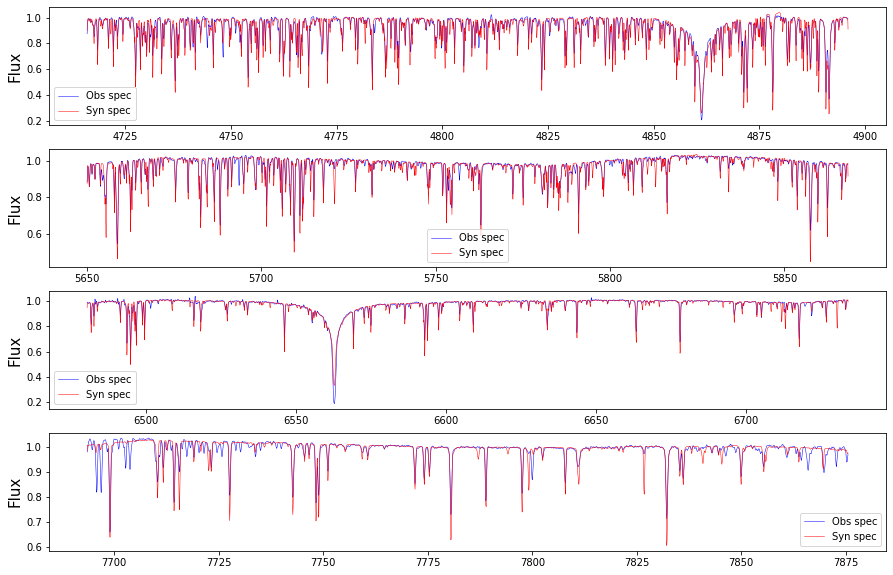

In [16]:
ccd = dict()
for each_ccd in range(4):
    ccd[each_ccd] = (wavelength > 1000*(4+each_ccd)) & (wavelength < 1000*(5+each_ccd))

f, gs = plt.subplots(4,1,figsize=(15,10))
for it in range(4):
    ax=gs[it]
    ax.plot(wavelength[ccd[it]], flux_each[ccd[it]], 'b', lw=0.5)
    ax.plot(wavelength[ccd[it]], fitted_spectra[ccd[it]], 'r', lw=0.5)
    
    ax.legend(labels=['Obs spec','Syn spec'],loc='best')
    ax.set_ylabel('Flux',fontsize=15)
fig = plt.gcf()